# Output distirbutions of ParT

In [1]:
import torch
import numpy as np
import normflows as nf
import os

from matplotlib import pyplot as plt

from tqdm import tqdm

from jet_dataset import JetDataset

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

/beegfs/desy/user/bierings/conda/envs/bayesconda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


['label_top' 'jet_pt' 'jet_eta' 'jet_phi' 'jet_energy' 'jet_nparticles'
 'jet_sdmass' 'jet_tau1' 'jet_tau2' 'jet_tau3' 'jet_tau4'
 'aux_genpart_eta' 'aux_genpart_phi' 'aux_genpart_pid' 'aux_genpart_pt'
 'aux_truth_match']
1.0
1.0
1.0


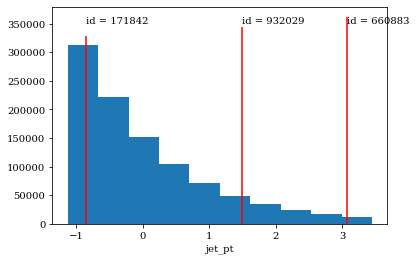

In [3]:
##################################################
### get validation from the distribution tails ###
##################################################

dataset_val = JetDataset("./jet_data", 'val')
labels = np.array(dataset_val.data.keys())[2:]

print(labels)

plt.hist(dataset_val.features[:,1])
plt.xlabel(labels[1])


sort = np.argsort(dataset_val.features[:,1])
for i in [200003, -100005, -10000]:
    plt.vlines(dataset_val.features[sort[i],1], *plt.ylim(), color = 'red', label='target')
    plt.text(dataset_val.features[sort[i],1], 350000, f'id = {sort[i]}')
    print(dataset_val.features[sort[i],0])

tensor([[-1.0000, -0.8518, -1.0476, -0.0032]])
tensor([[ 1.0000, -0.8518, -0.8592, -0.1802]])


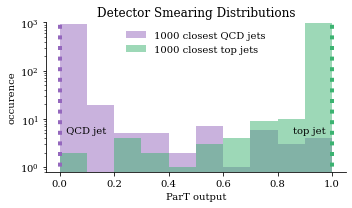

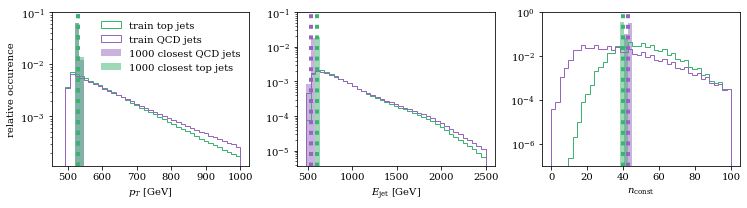

In [66]:
n_plot = 1000
#n_stat_alea = 500
bins = np.linspace(0,1,11)
bins_add = [np.linspace(480,1000,40), np.linspace(480,2500,40), np.linspace(0,100,43)]

colors = ['C4', 'mediumseagreen']
labels = [f'{n_plot} closest QCD jets', f'{n_plot} closest top jets']
texts = ['  QCD jet', 'top jet  ']
has = ['left', 'right']

dont_use = ['jet_eta', 'jet_phi', 'jet_sdmass', 
            'jet_tau1',	'jet_tau2',	'jet_tau3',	'jet_tau4',
            'aux_genpart_eta', 'aux_genpart_phi', 'aux_genpart_pid', 'aux_genpart_pt', 'aux_truth_match']

titles = [r'$p_T$ [GeV]', r'$E_\mathrm{jet}$ [GeV]', r'$n_\mathrm{const}$']

fig, ax = plt.subplots(1,1, figsize = (5,3))
n_plots = 16-len(dont_use)-1
fig_add, axs_add = plt.subplots(1,n_plots, figsize = (n_plots*3.5,3))

for j,k in enumerate([200001, 200003]):#, -100005, -10000]:
    dataset_train = JetDataset("./jet_data", 'train', del_context=dont_use)
    conditions_train = np.array(dataset_train.features).copy()

    dataset_val = JetDataset("./jet_data", 'val', del_context=dont_use)
    conditions = np.array(dataset_val.features)
    sort_tmp = np.argsort(dataset_val.features[:,1])
    i = sort_tmp[k]

    jet_mask = conditions_train[:,0] == conditions[i,0]
    dataset_train.target = dataset_train.target[jet_mask]
    conditions_train = conditions_train[jet_mask]

    dist_tmp = np.sum((conditions_train-conditions[i])**2, axis=1)
    sort = np.argsort(dist_tmp)

    x_data = torch.Tensor(dataset_train.target[sort[:n_plot]]*20)
    x_data_features = torch.Tensor(conditions_train[sort[:n_plot]])

    x_target = torch.Tensor(dataset_val.target[i:i+1]*20)
    x_target_features = torch.Tensor(dataset_val.features[i:i+1])
    print(x_target_features)
    assert n_plots+1 == x_target_features.shape[1]
    for i_plot in range(n_plots):
        if j == 0:
            mask = dataset_train.features[:,0] == 1
            _,b,_ = axs_add[i_plot].hist(dataset_train.features[:,i_plot+1][mask]*dataset_train.std_norm[:,i_plot+1] + dataset_train.means_norm[:,i_plot+1],
                        histtype = 'step', density = True, bins = bins_add[i_plot], color = colors[1], label = 'train top jets')
            mask = dataset_train.features[:,0] == -1.
            v,b,_ = axs_add[i_plot].hist(dataset_train.features[:,i_plot+1][mask]*dataset_train.std_norm[:,i_plot+1] + dataset_train.means_norm[:,i_plot+1],
                        histtype = 'step', density = True, bins = bins_add[i_plot], color = colors[0], label = 'train QCD jets')

        #axs_add[0].legend()
        _,b,_ = axs_add[i_plot].hist(x_data_features[:,i_plot+1]*dataset_train.std_norm[:,i_plot+1] + dataset_train.means_norm[:,i_plot+1], label = labels[j], color= colors[j], alpha = 0.5, bins = bins_add[i_plot],density = True)
        axs_add[i_plot].vlines(x_target_features[:,i_plot+1]*dataset_val.std_norm[:,i_plot+1] + dataset_val.means_norm[:,i_plot+1], 0, 1, color = colors[j], linestyles=':', linewidth = 4)

    _,b,_ = ax.hist(torch.sigmoid(x_data).numpy(), label = labels[j], color= colors[j], alpha = 0.5, bins = bins)
    ax.vlines(torch.sigmoid(x_target).numpy(), 0.01, 1000, color = colors[j], linestyles=':', linewidth = 4)
    ax.text(torch.sigmoid(x_target).numpy(), 5, texts[j], ha = has[j])
    ax.set_yscale('log')
    ax.set_xlabel(r'ParT output')
    ax.set_ylabel('occurence')
    ax.legend(frameon=False)

ax.set_title('Detector Smearing Distributions')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0.8,1000)
fig.tight_layout()
fig.savefig(f'./figs/data/detector_smearing_distr.pdf')


for i_plot in range(n_plots):
    axs_add[i_plot].set_yscale('log')
    axs_add[i_plot].set_ylim(None,[0.1,0.1,1][i_plot])
    axs_add[i_plot].set_xlabel(titles[i_plot])
axs_add[0].set_ylabel('relative occurence')
axs_add[0].legend(frameon=False)
fig_add.tight_layout()
fig_add.savefig(f'./figs/data/detector_smearing_distr_features.pdf')




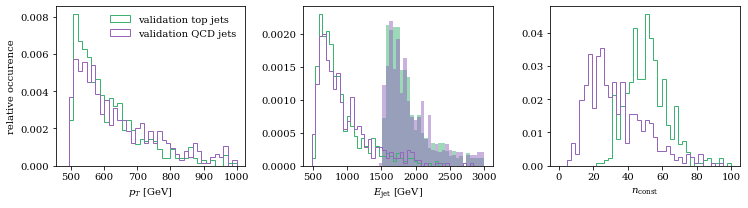

In [14]:
n_plot = 1000
#n_stat_alea = 500
bins = np.linspace(0,1,11)
bins_add = [np.linspace(480,1000,40), np.linspace(480,3000,50), np.linspace(0,100,43)]

colors = ['C4', 'mediumseagreen']
labels = [f'{n_plot} closest QCD jets', f'{n_plot} closest top jets']
texts = ['  QCD jet', 'top jet  ']
has = ['left', 'right']

dont_use = ['jet_eta', 'jet_phi', 'jet_sdmass', 
            'jet_tau1',	'jet_tau2',	'jet_tau3',	'jet_tau4',
            'aux_genpart_eta', 'aux_genpart_phi', 'aux_genpart_pid', 'aux_genpart_pt', 'aux_truth_match']

titles = [r'$p_T$ [GeV]', r'$E_\mathrm{jet}$ [GeV]', r'$n_\mathrm{const}$']

n_plots = 16-len(dont_use)-1
fig_add, axs_add = plt.subplots(1,n_plots, figsize = (n_plots*3.5,3))

jet = 'both'

add = [0, 1000, 0]

dataset_train = JetDataset("./jet_data", 'val', del_context=dont_use)
dataset_train.features = dataset_train.features[np.random.permutation(len(dataset_train.features))][:1000]

for i_plot in range(n_plots):
    if add[i_plot] != 0:
        if jet != 'QCD':
            mask = dataset_train.features[:,0] == 1
            _,b,_ = axs_add[i_plot].hist(dataset_train.features[:,i_plot+1][mask]*dataset_train.std_norm[:,i_plot+1] + dataset_train.means_norm[:,i_plot+1] + add[i_plot],
                        histtype = 'stepfilled', density = True, bins = bins_add[i_plot], color = colors[1], label = 'validation top jets', alpha = 0.5)
        if jet != 'top':
            mask = dataset_train.features[:,0] == -1.
            v,b,_ = axs_add[i_plot].hist(dataset_train.features[:,i_plot+1][mask]*dataset_train.std_norm[:,i_plot+1] + dataset_train.means_norm[:,i_plot+1]+ add[i_plot],
                        histtype = 'stepfilled', density = True, bins = bins_add[i_plot], color = colors[0], label = 'validation QCD jets', alpha = 0.5)

    if jet != 'QCD':
        mask = dataset_train.features[:,0] == 1
        _,b,_ = axs_add[i_plot].hist(dataset_train.features[:,i_plot+1][mask]*dataset_train.std_norm[:,i_plot+1] + dataset_train.means_norm[:,i_plot+1],
                    histtype = 'step', density = True, bins = bins_add[i_plot], color = colors[1], label = 'validation top jets')
    if jet != 'top':
        mask = dataset_train.features[:,0] == -1.
        v,b,_ = axs_add[i_plot].hist(dataset_train.features[:,i_plot+1][mask]*dataset_train.std_norm[:,i_plot+1] + dataset_train.means_norm[:,i_plot+1],
                    histtype = 'step', density = True, bins = bins_add[i_plot], color = colors[0], label = 'validation QCD jets')


for i_plot in range(n_plots):
    #axs_add[i_plot].set_ylim(None,[0.1,0.1,1][i_plot])
    axs_add[i_plot].set_xlabel(titles[i_plot])
axs_add[0].set_ylabel('relative occurence')
axs_add[0].legend(frameon=False)
fig_add.tight_layout()
fig_add.savefig(f'./figs/data/features_shift.pdf')




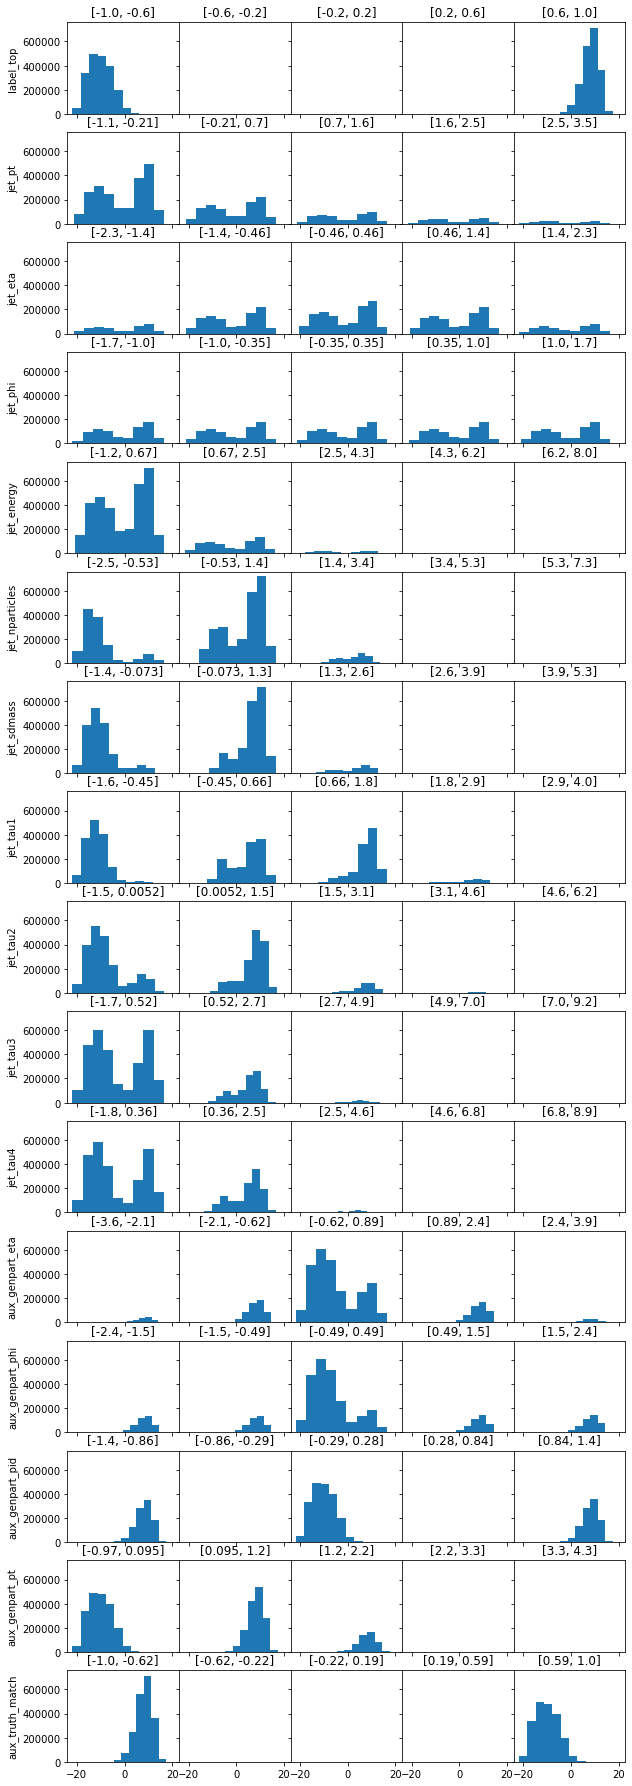

In [10]:
#plot over input bins

n_bins = 5
dataset_train = JetDataset("./jet_data",'train')
labels = np.array(dataset_train.data.keys())[2:]

fig, ax = plt.subplots(dataset_train.features.shape[1], n_bins, figsize = (2*n_bins, 2*dataset_train.features.shape[1]), sharex=True, sharey=True)

for i_f in range(dataset_train.features.shape[1]):
    print(i_f, end = '\r')
    bins = np.linspace(dataset_train.features[:,i_f].min(), dataset_train.features[:,i_f].max(), n_bins+1)

    for i_b in range(n_bins):

        mask = np.bitwise_and(dataset_train.features[:,i_f]>=bins[i_b], dataset_train.features[:,i_f]<=bins[i_b+1])
        ax[i_f,i_b].hist(dataset_train.target[mask]*20)
        ax[i_f,0].set_ylabel(labels[i_f])
        ax[i_f,i_b].set_title(f'[{bins[i_b]:3.2}, {bins[i_b+1]:3.2}]')

fig.subplots_adjust(wspace=0.)

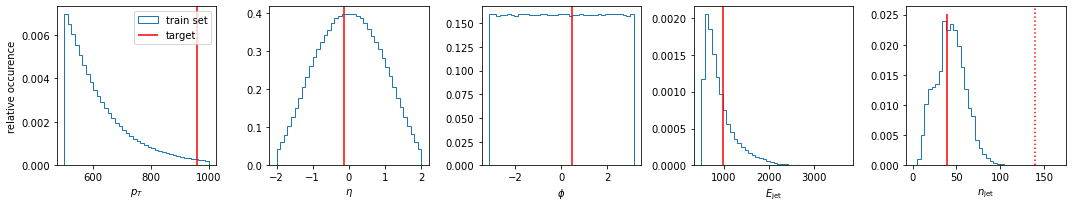

In [16]:
n_plot = 100
#n_stat_alea = 500

color = 'C4'


k = -10000

dont_use = ['jet_sdmass', 
            'jet_tau1',	'jet_tau2',	'jet_tau3',	'jet_tau4',
            'aux_genpart_eta', 'aux_genpart_phi', 'aux_genpart_pid', 'aux_genpart_pt', 'aux_truth_match']

dataset_train = JetDataset("./jet_data", 'train', del_context=dont_use)
conditions_train = np.array(dataset_train.features)

dataset_val = JetDataset("./jet_data", 'val', del_context=dont_use)
conditions = np.array(dataset_val.features)
sort_tmp = np.argsort(dataset_val.features[:,1])
i = sort_tmp[k]

#mask_top = dataset_train.features[:,0] ==1
#mask_ntop = dataset_train.features[:,0] !=1

titles = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E_\mathrm{jet}$', r'$n_\mathrm{jet}$', ]
fig, ax = plt.subplots(1, conditions.shape[1]-1, figsize = (15,3))
for j, a in enumerate(ax):
    _,b,_ = ax[j].hist(conditions_train[:,j+1]*dataset_train.std_norm[:,j+1] + dataset_train.means_norm[:,j+1],
                histtype = 'step', density = True, bins = 40, label='train set')
    ax[j].vlines(conditions[i,j+1]*dataset_val.std_norm[:,j+1] + dataset_val.means_norm[:,j+1],
                    *ax[j].get_ylim(), color = 'red', label='target')
    if j == 4:
        conditions[:,j+1] = (conditions[:,j+1]*dataset_val.std_norm[0,j+1]+100)/dataset_val.std_norm[0,j+1]
        ax[j].vlines(conditions[i,j+1]*dataset_val.std_norm[:,j+1] + dataset_val.means_norm[:,j+1],
            *ax[j].get_ylim(), color = 'red', linestyle = ':')
    ax[j].set_xlabel(titles[j])
    ax[j].set_ylim(ax[j].get_ylim()[0], ax[j].get_ylim()[1]*0.95)

ax[0].legend()
ax[0].set_ylabel('relative occurence')
plt.tight_layout()
plt.savefig(f'./out_{i}_neighbors_shift.pdf')
plt.show()


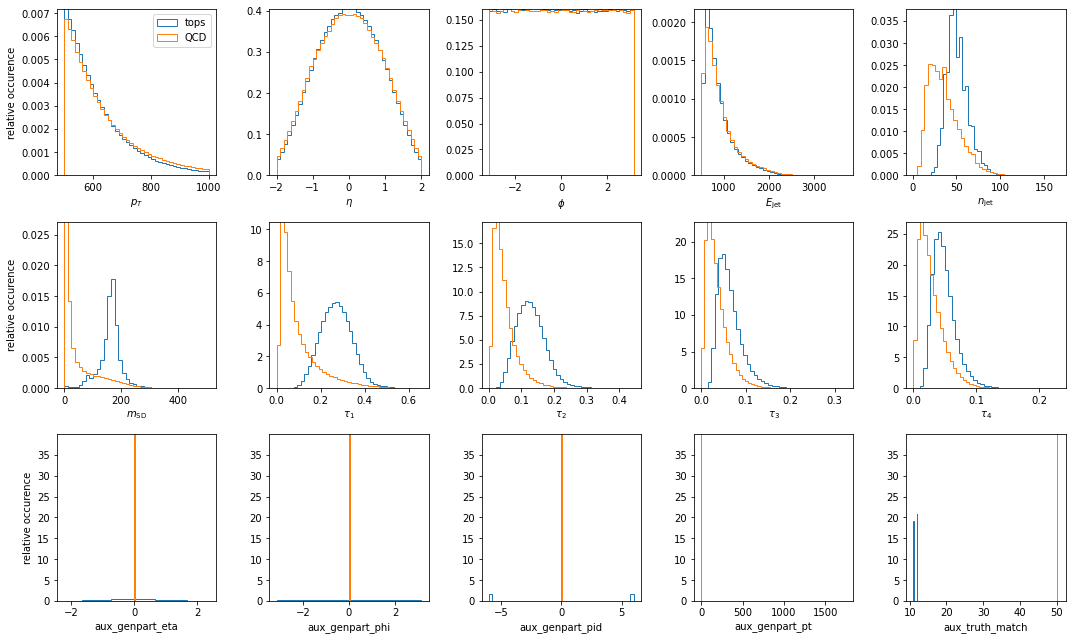

In [4]:

dataset_train = JetDataset("./jet_data", 'train')
conditions_train = np.array(dataset_train.features)

rows = 3
columns =  (conditions_train.shape[1]-1)//rows

mask_top = dataset_train.features[:,0] ==1
mask_ntop = dataset_train.features[:,0] !=1

titles = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E_\mathrm{jet}$', r'$n_\mathrm{jet}$', r'$m_\mathrm{SD}$', r'$\tau_1$', r'$\tau_2$', r'$\tau_3$', r'$\tau_4$']+dataset_train.keys[11:]
fig, ax = plt.subplots(rows, columns, figsize = (3*columns,3*rows))
ax = ax.flatten()
for j, a in enumerate(ax):
    _,b,_ = ax[j].hist(conditions_train[mask_top,j+1]*dataset_train.std_norm[:,j+1] + dataset_train.means_norm[:,j+1],
                histtype = 'step', density = True, bins = 40, label='tops')
    _,b,_ = ax[j].hist(conditions_train[mask_ntop,j+1]*dataset_train.std_norm[:,j+1] + dataset_train.means_norm[:,j+1],
                histtype = 'step', density = True, bins = 40, label='QCD')
    ax[j].set_xlabel(titles[j])
    ax[j].set_ylim(ax[j].get_ylim()[0], ax[j].get_ylim()[1]*0.95)

for n in range(rows):
    ax[n*columns].set_ylabel('relative occurence')
ax[0].legend()
plt.tight_layout()
#plt.savefig(f'./out_{i}_neighbors_shift.pdf')
plt.show()